<a href="https://colab.research.google.com/github/hglezquiqui/PG_MTR/blob/main/Lasso_PG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/MTR Framework/') 
dataset={'name':['wq'],
         'output':[14]
         }

In [ ]:
import numpy as np
import matplotlib.pyplot as pp


# Objective function: f(x) + lambda*norm1(x)

In [ ]:
def obj(A,x,b,lamda):
    #assert(np.size(x,0)==np.size(A,1) and np.size(A,0) == np.size(b,0) and \
    #np.size(x,1)== np.size(b,1) == 1 and np.isscalar(lamda))
    return f(A,x,b) + lamda*np.sum(np.sum(np.abs(x)))

# f(x) = (1/2)||Ax-b||^2

In [ ]:
def f(A,x,b):
    #assert(np.size(x,0)==np.size(A,1) and np.size(A,0) == np.size(b,0))
    Ax_b = A.dot(x) - b
    return 0.5*(np.trace(Ax_b.T.dot(Ax_b)))

# gradient of f(x) 

In [ ]:
def grf(A,x,b):
    assert(np.size(x,0)==np.size(A,1) and np.size(A,0) == np.size(b,0))
    return A.T.dot(A.dot(x) - b)

# Model function evaluated at x and touches f(x) in xk

In [ ]:
def m(x,xk,A,b,GammaK):
    #assert(np.size(xk,0) == np.size(x,0) == np.size(A,1) \
    #and np.size(A,0) == np.size(b,0) and np.isscalar(GammaK))
    innerProd = grf(A,xk,b).T.dot(x - xk)
    xDiff = x - xk
    return f(A,xk,b) + np.trace(innerProd) + (1.0/(2.0*GammaK))*np.trace(xDiff.T.dot(xDiff))

# Shrinkage or Proximal operation

In [ ]:
def proxNorm1(y,lamda):
    #assert(np.size(y,1)==1)
    return np.sign(y)*np.maximum(np.zeros(np.shape(y)),np.abs(y)-lamda)

In [ ]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
from scipy.io import arff

def read_mtr_arff1(dataset):
  dataset_name=dataset['name'][0]
  q=dataset['output'][0]
  #print(q)
  pthTr=dataset_name+'/' + dataset_name+'-train.arff'
  xTr=arff.loadarff(pthTr)
  df = pd.DataFrame(xTr[0])

  XTr = df.iloc[:,:-q]
  YTr = df.iloc[:,-q:]
  pthTe=dataset_name+'/' + dataset_name+'-test.arff'
  xTe=arff.loadarff(pthTe)
  df = pd.DataFrame(xTe[0])

  XTe = df.iloc[:,:-q]
  YTe = df.iloc[:,-q:]
  #print(YTr)
  sc = StandardScaler()
  XTr=sc.fit_transform(XTr)
  XTe=sc.transform(XTe)
  YTr=sc.fit_transform(YTr)
  YTe=sc.transform(YTe)

  
  return XTr, XTe, YTr, YTe 

In [ ]:
X_train, X_test, y_train, y_test = read_mtr_arff1(dataset)
#print(y_train)

In [ ]:
def lasso_pgfit(A,b):
  # Define parameters. Size of A is n x p
  p = np.size(A,1)
  n = np.size(A,0)

  kMax = 500   # Number of iteration
  beta = 0.75 # decreasing factor for line search
  q=np.size(b,1)
  # Generate the sparse vector xStar
  # and Randomly set 20 elements
  """
  xStar = np.zeros((p,q))
  xStar[np.floor(p*np.random.rand(20,q)).astype(np.int)]=1
  xStar = xStar*np.random.normal(0,10,(p,q))

  # Generate A and b. b = Ax + error
  A = np.random.randn(n,p)
  b = A.dot(xStar) + np.random.randn(n,q)
  """
  lamda = np.sqrt(2*n*np.log(p)).tolist()
  #lamda = 1.

  # For Proximal Gradient Descent
  xk = np.random.rand(p,q) # Initialize with random
  #xk = np.zeros((p,q))      # Initialize with zero

  # For Accelerated Proximal Gradient Descent    
  xk_acc = xk.copy()
  yk_acc = xk_acc
  tk_acc = 1
  stopUpdate_acc = False
  Dobj_acc = 0
  cri=[]
  fobj=[]
  
  for k in range(kMax):
      
      # ------------------------- Proximal GD -----------------------------        
      Gammak = 0.01
      #Gammak = 1/np.linalg.norm(A.T.dot(A))      
      
      # Line search
      while True:
          #print ('trying stepsize = ', "{0:0.2e}".format(Gammak))
          x_kplus1 = xk - Gammak*grf(A,xk,b)        # Gradient Descent (GD) Step

          #print(m(x_kplus1,xk,A,b,Gammak))
          if f(A,x_kplus1,b) <= m(x_kplus1,xk,A,b,Gammak):
              #print ' success'
              break
          else:
              #print ' Fail ',
              Gammak = beta*Gammak
      x_kplus1 = proxNorm1(x_kplus1,Gammak*lamda)   # Proximal Operation (Shrinkage)
      
      # Change in the value of objective funtion for this iteration
      Dobj = np.linalg.norm(obj(A,x_kplus1,b,lamda) - obj(A,xk,b,lamda))
      # print 'k:',k, ' obj = ', obj(A,x_kplus1,b,lamda), 'Change = ',Dobj
      
      # Update xk
      xk = x_kplus1.copy()
      # --------------------------------------------------------------------

      # =================== Accelerated Proximal GD ========================
      #Gammak = 1/np.linalg.norm(A.T.dot(A))
      Gammak = 0.01
      # Line search
      while True:
          # Accelerated Gradient Descent (GD) Step
          x_kplus1_acc = yk_acc - Gammak*grf(A,yk_acc,b)        
          if f(A,x_kplus1_acc,b) <= m(x_kplus1_acc,xk_acc,A,b,Gammak):
              break
          else:
              Gammak = beta*Gammak
      # Proximal Operation (Shrinkage)
      x_kplus1_acc = proxNorm1(x_kplus1_acc,Gammak*lamda)   
      t_kplus1_acc = 0.5 + 0.5*np.sqrt(1+4*(tk_acc**2.))
      y_kplus1_acc = x_kplus1_acc + ((tk_acc - 1)/(tk_acc + 1))*\
      (x_kplus1_acc - xk_acc)

      # Change in the value of objective funtion for this iteration
      Dobj_acc = np.linalg.norm(obj(A,x_kplus1_acc,b,lamda) - \
      obj(A,xk_acc,b,lamda))
      
      # Update
      xk_acc = x_kplus1_acc
      tk_acc = t_kplus1_acc
      yk_acc =  y_kplus1_acc
      cri.append(obj(A,xk_acc,b,lamda))
      fobj.append(obj(A,xk,b,lamda))
      # ====================================================================        

      # Terminating Condition        
      if (Dobj < 1) and (Dobj_acc < 1):
          break
  return xk, xk_acc, cri,fobj
 

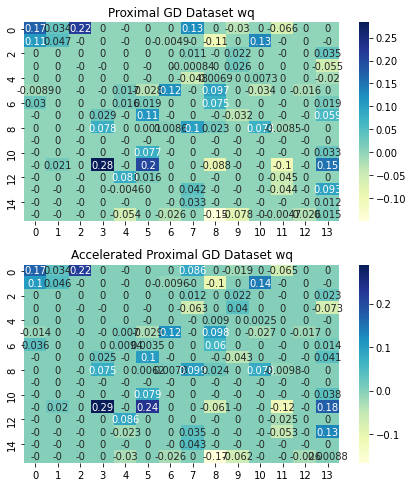

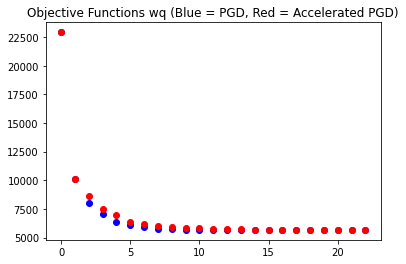

In [ ]:
import seaborn as sbn
xk, xk_acc, cri,fobj=lasso_pgfit(X_train,y_train)
     # Graphical Display - plot x and reconstructed x
pp.figure('Sparse code',figsize=(6,10))
pp.clf() 
"""       
pp.subplot(311)    
pp.plot(xStar)
pp.title('Original x')
"""
pp.subplot(311)
#print(xk)
sbn.heatmap(xk,annot=True,cmap='YlGnBu')
pp.title('Proximal GD Dataset '+dataset['name'][0])
pp.subplot(312)
sbn.heatmap(xk_acc,annot=True,cmap='YlGnBu')
pp.title('Accelerated Proximal GD Dataset '+dataset['name'][0])
pp.tight_layout()
pp.draw()
pp.pause(0.1)
#print(xk_acc)
# Graphical Display - plot objective function values
if len(cri) > 5:
    #pp.figure('Objective function values')
    #pp.subplot(211)
    #pp.scatter(k,-1*np.log(obj(A,xk,b,lamda)),c = 'b')
    #pp.scatter(k,-1*np.log(obj(A,xk_acc,b,lamda)),c = 'r')
    v= [x for x in range(len(cri))]
    pp.scatter(v,cri,c = 'b')
    pp.scatter(v,fobj,c = 'r')
    pp.title(\
    'Objective Functions '+ dataset['name'][0] +' (Blue = PGD, Red = Accelerated PGD)')
    #pp.subplot(212)
#            pp.scatter(k,-1*np.log(Dobj),c = 'b')
#            pp.scatter(k,-1*np.log(Dobj_acc),c = 'r')
#            print 'k:',k, ' Change (Proximal) = ', Dobj, ' Change (Accelerated Proximal) = ',Dobj_acc
#            pp.title('-log of change in Objective Functions (Blue = PGD, Red = Accelerated PGD)')        
    pp.draw()
    pp.pause(0.1)        

pp.show()